## MPAA rating prediction

In [1]:
import pandas as pd
import numpy as np
import warnings
import re
import pickle
import seaborn as sns

%matplotlib inline
warnings.filterwarnings('ignore')

Import dataset :: using the rotten tomatoes dataset

In [2]:
dataset_df = pd.read_csv( './rtt_dataset/all_movie.csv' )
dataset_df = dataset_df[['Title', 'Rating', 'Description']]
dataset_df.columns = dataset_df.columns.str.strip()
dataset_df.head(4)

,Title,Rating,Description
0,The Mummy: Tomb of the Dragon Emperor,PG-13,The Fast and the Furious director Rob Cohen co...
1,The Masked Saint,PG-13,The journey of a professional wrestler who bec...
2,Spy Hard,PG-13,"Dead pan Leslie Nielsen stars as Dick Steele, ..."
3,Der Baader Meinhof Komplex (The Baader Meinhof...,R,Director Uli Edel teams with screenwriter Bern...


In [3]:
# finding unique mpaa rating in the dataset
dataset_df['Rating'].unique()

array(['PG-13 ', 'PG-13', 'R ', 'NR', 'PG', 'G', 'PG ', 'R', 'G ', 'NR ',
       'NC17', 'NC17 '], dtype=object)

In [4]:
# clean mpaa ratings
mpaa_fix = {
    'PG-13 ' : 'PG-13',
    'R ' : 'R',
    'PG ': 'PG',
    'G ' : 'G',
    'NR ': 'NR',
    'NC17 ': 'NC17'
}
for i, rating in dataset_df['Rating'].iteritems():
    if rating in mpaa_fix.keys():
        fix_val = mpaa_fix.get(rating)
        dataset_df.iloc[i]['Rating'] = fix_val
dataset_df['Rating'].unique()

array(['PG-13', 'R', 'NR', 'PG', 'G', 'NC17'], dtype=object)

In [5]:
# Clean the movie description
def clean_description( text_str ):
    text = re.sub('[^a-zA-Z]',  ' ', text_str)
    text = re.sub(r'\s+[a-zA-Z]\s+', ' ', text)
    text = re.sub(r'\s+', ' ', text)
    return text

for i, description in dataset_df['Description'].iteritems():
    dataset_df.iloc[i]['Description'] = clean_description( str(description) )

In [6]:
pickle.dump(dataset_df, open('./data/dataset_df_cleaned.pkl', 'wb'))

## Data Distribution

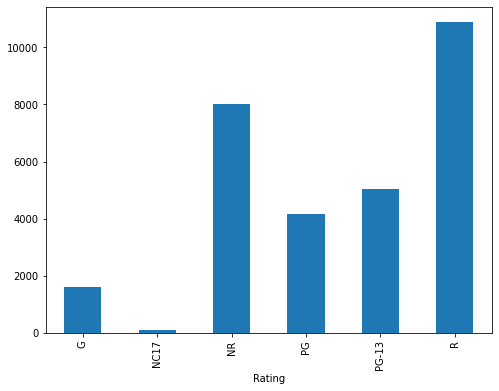

In [7]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(8,6))
dataset_df.groupby('Rating')['Description'].count().plot.bar(ylim=0)
plt.show()

## Training model

In [8]:
training_df = pickle.load( open('./data/dataset_df_cleaned.pkl', 'rb') )

In [9]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.preprocessing.text import one_hot, Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.models import Sequential, load_model
from keras.layers import Dense, Flatten, LSTM, Embedding, GlobalMaxPooling1D

In [10]:
_y = training_df['Rating']
encoder = LabelEncoder()
Y = encoder.fit_transform(_y)
Y

array([4, 4, 4, ..., 5, 4, 4])

In [11]:
X = training_df['Description']
X

0        The Fast and the Furious director Rob Cohen co...
1        The journey of professional wrestler who becom...
2        Dead pan Leslie Nielsen stars as Dick Steele a...
3        Director Uli Edel teams with screenwriter Bern...
4        One of cluster of late films about the Vietnam...
                               ...                        
29805    Filmed at least nine times over the last nine ...
29806    Fred MacMurray stars in this Walt Disney comed...
29807    A resident of rd century Earth becomes involve...
29808    Supernova chronicles the search and rescue pat...
29809    For years there have been documented cases of ...
Name: Description, Length: 29810, dtype: object

## Train, test split

In [12]:
X_train, X_test, Y_train, Y_test = train_test_split( X, Y, test_size=0.3, random_state=40 )

In [13]:
Y_train = to_categorical(Y_train)
Y_test  = to_categorical(Y_test)

In [14]:
tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(X_train)

In [15]:
X_train = tokenizer.texts_to_sequences(X_train)
X_test  = tokenizer.texts_to_sequences(X_test)

In [16]:
vocabulary_size = len(tokenizer.word_index) + 1
maxlen = 400 # Only concider first 400 words of each description

X_train = pad_sequences( X_train, maxlen=maxlen )
X_test  = pad_sequences( X_test, maxlen=maxlen )

## Use GloVe : Global Vectors for Word Representation
https://nlp.stanford.edu/projects/glove/

GloVe is an unsupervised learning algorithm for obtaining vector representations for words. Training is performed on aggregated global word-word co-occurrence statistics from a corpus, and the resulting representations showcase interesting linear substructures of the word vector space. 

In [17]:
glove_file = open('./glove.6B/glove.6B.100d.txt', encoding='utf8')

In [18]:
embedd_dictionary = dict()
for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dims = np.asarray(records[1:], dtype='float32')
    embedd_dictionary[word] = vector_dims

glove_file.close()

In [19]:
embedd_matrix = np.zeros((vocabulary_size, 100))
for word, index in tokenizer.word_index.items():
    embedd_vector = embedd_dictionary.get(word)
    if embedd_vector is not None:
        embedd_matrix[index] = embedd_vector

## Build the NN Model

In [20]:
model = Sequential()
model.add(Embedding(input_dim=vocabulary_size, output_dim=100, weights=[embedd_matrix], trainable=False))
model.add(LSTM(units=128, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(6, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 100)         5635900   
_________________________________________________________________
lstm (LSTM)                  (None, 128)               117248    
_________________________________________________________________
dense (Dense)                (None, 6)                 774       
Total params: 5,753,922
Trainable params: 118,022
Non-trainable params: 5,635,900
_________________________________________________________________


In [21]:
hist = model.fit(X_train, Y_train, batch_size=128, epochs=40, validation_split=0.30, verbose=1)

Epoch 1/40
115/115 [==============================] - 164s 1s/step - loss: 1.5095 - accuracy: 0.3439 - val_loss: 1.4125 - val_accuracy: 0.4055
Epoch 2/40
115/115 [==============================] - 162s 1s/step - loss: 1.3971 - accuracy: 0.4056 - val_loss: 1.3069 - val_accuracy: 0.4479
Epoch 3/40
115/115 [==============================] - 132s 1s/step - loss: 1.3153 - accuracy: 0.4437 - val_loss: 1.3305 - val_accuracy: 0.4183
Epoch 4/40
115/115 [==============================] - 75s 654ms/step - loss: 1.2823 - accuracy: 0.4509 - val_loss: 1.2594 - val_accuracy: 0.4622
Epoch 5/40
115/115 [==============================] - 80s 701ms/step - loss: 1.2385 - accuracy: 0.4801 - val_loss: 1.2706 - val_accuracy: 0.4581
Epoch 6/40
115/115 [==============================] - 76s 665ms/step - loss: 1.2255 - accuracy: 0.4933 - val_loss: 1.2076 - val_accuracy: 0.4988
Epoch 7/40
115/115 [==============================] - 73s 633ms/step - loss: 1.1843 - accuracy: 0.5162 - val_loss: 1.1897 - val_accuracy

In [22]:
loss, acc = model.evaluate(X_test, Y_test, verbose=1)
print('loss: ', loss)
print('accuracy: ', acc)

280/280 [==============================] - 16s 59ms/step - loss: 0.9836 - accuracy: 0.7125
loss:  0.9836333394050598
accuracy:  0.7125125527381897


## Save model and tokenizer

In [23]:
# save model
model.save('./data/mpaa_classifier.h5')

# save word tokenizer
pickle.dump(tokenizer, open('./data/tokenizer.pkl', 'wb'))

## Metrics

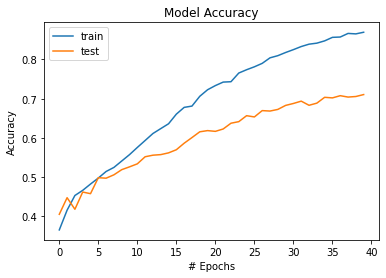

In [24]:
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('# Epochs')
plt.legend(['train', 'test'])
plt.show()

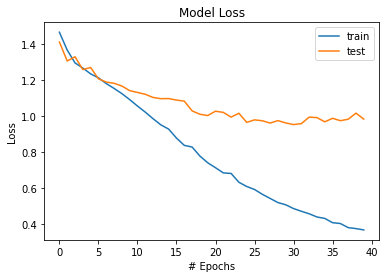

In [25]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('# Epochs')
plt.legend(['train', 'test'])
plt.show()